In [1]:
import torch
import torch.nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

from train import train_model, plot_training_curve

cudnn.benchmark = True

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(
    root='dataset/diffusion/train', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset/diffusion/val', transform=transform)
image_datasets = {'train': train_dataset, 'val': val_dataset}

dataloaders = {'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=32, shuffle=False)}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
res_weights = models.ResNet50_Weights.DEFAULT
res_model = models.resnet50(weights=res_weights).to(device)

google_weights = models.GoogLeNet_Weights.DEFAULT
google_model = models.googlenet(weights=google_weights).to(device)

efficient_weights = models.EfficientNet_B0_Weights.DEFAULT
efficient_model = models.efficientnet_b0(weights=efficient_weights).to(device)

trained_models = {'ResNet-50': res_model, 'GoogleNet': google_model,
          'EfficientNet-b0': efficient_model}
results = {}

In [4]:
torch.manual_seed(493)
torch.cuda.manual_seed(493)

loss_fn = torch.nn.CrossEntropyLoss()
in_features = {'ResNet-50': 2048, 'GoogleNet': 1024, 'EfficientNet-b0': 1280}

for model_name, model in trained_models.items():

    for param in model.parameters():
        param.requires_grad = False

    model = torch.nn.Sequential(*list(model.children())[:-1])

    new_layers = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=in_features[model_name],
                        out_features=2,
                        bias=True)).to(device)

    model = torch.nn.Sequential(model, new_layers).to(device)

    for param in new_layers.parameters():
        param.requires_grad = True

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

    model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, dataloaders, dataset_sizes, loss_fn, optimizer, device, num_epochs=12)
    torch.save(model, f'E:\\Local\\CSE493\\{model_name}.pth')
    results[model_name] = (train_losses, val_losses,
                           train_accuracies, val_accuracies)

Epoch 1/12
----------
train Loss: 0.5137 Acc: 0.7560
val Loss: 0.4406 Acc: 0.8300

Epoch 2/12
----------
train Loss: 0.3980 Acc: 0.8358
val Loss: 0.3979 Acc: 0.8233

Epoch 3/12
----------
train Loss: 0.3548 Acc: 0.8566
val Loss: 0.3790 Acc: 0.8317

Epoch 4/12
----------
train Loss: 0.3379 Acc: 0.8638
val Loss: 0.3757 Acc: 0.8333

Epoch 5/12
----------
train Loss: 0.3228 Acc: 0.8687
val Loss: 0.3544 Acc: 0.8283

Epoch 6/12
----------
train Loss: 0.3148 Acc: 0.8731
val Loss: 0.3457 Acc: 0.8467

Epoch 7/12
----------
train Loss: 0.3165 Acc: 0.8689
val Loss: 0.3403 Acc: 0.8567

Epoch 8/12
----------
train Loss: 0.3002 Acc: 0.8738
val Loss: 0.3442 Acc: 0.8550

Epoch 9/12
----------
train Loss: 0.3043 Acc: 0.8751
val Loss: 0.3463 Acc: 0.8500

Epoch 10/12
----------
train Loss: 0.2966 Acc: 0.8772
val Loss: 0.3424 Acc: 0.8500

Epoch 11/12
----------
train Loss: 0.2976 Acc: 0.8771
val Loss: 0.3370 Acc: 0.8500

Epoch 12/12
----------
train Loss: 0.2918 Acc: 0.8783
val Loss: 0.3380 Acc: 0.8617

T

In [9]:
plot_training_curve('ResNet-50', *results['ResNet-50'])
plot_training_curve('GoogleNet', *results['GoogleNet'])
plot_training_curve('EfficientNet-b0', *results['EfficientNet-b0'])

Loss curve saved to result\ResNet-50_loss_curve.png
Accuracy curve saved to result\ResNet-50_acc_curve.png
Loss curve saved to result\GoogleNet_loss_curve.png
Accuracy curve saved to result\GoogleNet_acc_curve.png
Loss curve saved to result\EfficientNet-b0_loss_curve.png
Accuracy curve saved to result\EfficientNet-b0_acc_curve.png


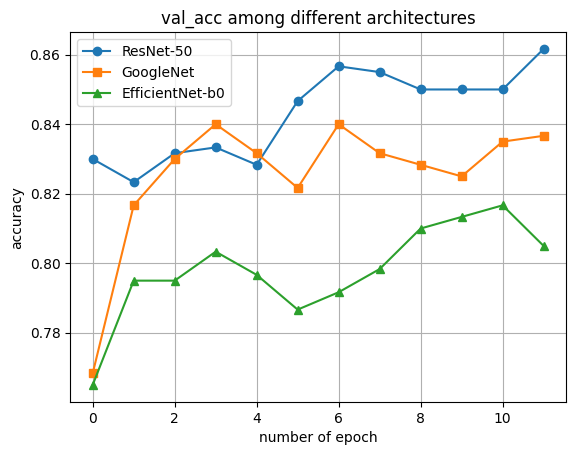

In [10]:
val_accuracies = []
for name, list in results.items():
    val_accuracies.append([acc.cpu().item() if torch.is_tensor(acc)
                           else acc for acc in results[name][3]])

plt.plot(val_accuracies[0], label='ResNet-50', marker='o')
plt.plot(val_accuracies[1], label='GoogleNet', marker='s')
plt.plot(val_accuracies[2], label='EfficientNet-b0', marker='^')

plt.xlabel('number of epoch')
plt.ylabel('accuracy')
plt.title('val_acc among different architectures')
plt.legend()

plt.grid(True)
plt.show()

# ViT Diffusion #

Epoch 1/12
----------
train Loss: 0.5467 Acc: 0.7204
val Loss: 0.4646 Acc: 0.7900

Epoch 2/12
----------
train Loss: 0.4418 Acc: 0.7998
val Loss: 0.4311 Acc: 0.8050

Epoch 3/12
----------
train Loss: 0.4162 Acc: 0.8104
val Loss: 0.4121 Acc: 0.8167

Epoch 4/12
----------
train Loss: 0.4047 Acc: 0.8138
val Loss: 0.4082 Acc: 0.8083

Epoch 5/12
----------
train Loss: 0.4036 Acc: 0.8150
val Loss: 0.4062 Acc: 0.8100

Epoch 6/12
----------
train Loss: 0.4030 Acc: 0.8197
val Loss: 0.3963 Acc: 0.8117

Epoch 7/12
----------
train Loss: 0.4015 Acc: 0.8179
val Loss: 0.3943 Acc: 0.8200

Epoch 8/12
----------
train Loss: 0.3999 Acc: 0.8175
val Loss: 0.4025 Acc: 0.8150

Epoch 9/12
----------
train Loss: 0.3976 Acc: 0.8212
val Loss: 0.3987 Acc: 0.8167

Epoch 10/12
----------
train Loss: 0.3950 Acc: 0.8209
val Loss: 0.4028 Acc: 0.8083

Epoch 11/12
----------
train Loss: 0.3981 Acc: 0.8196
val Loss: 0.4026 Acc: 0.8150

Epoch 12/12
----------
train Loss: 0.3943 Acc: 0.8237
val Loss: 0.3962 Acc: 0.8250

T

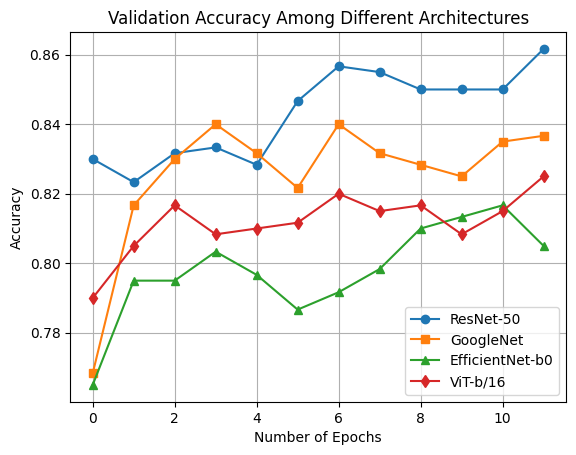

In [14]:
from torchvision.models import vit_b_16, ViT_B_16_Weights


vit_weights = ViT_B_16_Weights.DEFAULT
vit_model = vit_b_16(weights=vit_weights).to(device)


for param in vit_model.parameters():
    param.requires_grad = False


in_features = vit_model.heads[0].in_features
vit_model.heads = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=in_features, out_features=2, bias=True)
).to(device)


optimizer = torch.optim.Adam(vit_model.heads.parameters(), lr=0.0008)
loss_fn = torch.nn.CrossEntropyLoss()


vit_model, vit_train_losses, vit_val_losses, vit_train_accuracies, vit_val_accuracies = train_model(
    vit_model, dataloaders, dataset_sizes, loss_fn, optimizer, device, num_epochs=12
)


torch.save(vit_model, 'E:\\Local\\CSE493\\ViT-b16.pth')


vit_val_accuracies = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in vit_val_accuracies]


plt.plot(val_accuracies[0], label='ResNet-50', marker='o')
plt.plot(val_accuracies[1], label='GoogleNet', marker='s')
plt.plot(val_accuracies[2], label='EfficientNet-b0', marker='^')
plt.plot(vit_val_accuracies, label='ViT-b/16', marker='d')

plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Among Different Architectures')
plt.legend()
plt.grid(True)
plt.show()

# Blur and Noise Graph #

C:\Users\yzz99\AppData\Local\Temp\ipykernel_11864\3695113321.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models = {name: torch.load(path).to(device) for name, path 

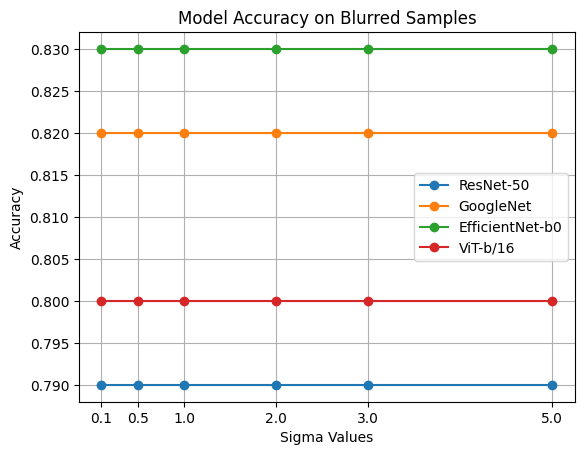

In [17]:
import os
import numpy as np
from sklearn.metrics import accuracy_score
from torchvision import datasets
from torch.utils.data import DataLoader


sigma_values = [0.1, 0.5, 1, 2, 3, 5]
blurred_dataset_path = "E:\\Local\\CSE493\\dataset\\diffusion\\blur\\diffusion_blur"


def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy


model_paths = {
    'ResNet-50': 'E:\\Local\\CSE493\\ResNet-50.pth',
    'GoogleNet': 'E:\\Local\\CSE493\\GoogleNet.pth',
    'EfficientNet-b0': 'E:\\Local\\CSE493\\EfficientNet-b0.pth',
    'ViT-b/16': 'E:\\Local\\CSE493\\ViT-b16.pth'
}
models = {name: torch.load(path).to(device) for name, path in model_paths.items()}


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


accuracies = {name: [] for name in models.keys()}

for sigma in sigma_values:
    sigma_path = os.path.join(blurred_dataset_path, f"sigma_{sigma}")
    dataset = datasets.ImageFolder(root=sigma_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    for name, model in models.items():
        acc = evaluate_model(model, dataloader, device)
        accuracies[name].append(acc)


for name, acc_list in accuracies.items():
    plt.plot(sigma_values, acc_list, label=name, marker='o')

plt.xlabel('Sigma Values')
plt.ylabel('Accuracy')
plt.title('Model Accuracy on Blurred Samples')
plt.xticks(sigma_values)
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms
import timm
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
from torchvision.models import resnet50
from PIL import Image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

e:\Local\CSE493\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Grad-CAM for CNNs #

Processing image: E:\Local\CSE493\dataset\diffusion\gradcam\diffusion1.png
Generating Grad-CAM for ResNet-50...
Generating Grad-CAM for GoogleNet...
Generating Grad-CAM for EfficientNet-B0...
Processing image: E:\Local\CSE493\dataset\diffusion\gradcam\diffusion2.png
Generating Grad-CAM for ResNet-50...
Generating Grad-CAM for GoogleNet...
Generating Grad-CAM for EfficientNet-B0...
Processing image: E:\Local\CSE493\dataset\diffusion\gradcam\diffusion3.png
Generating Grad-CAM for ResNet-50...
Generating Grad-CAM for GoogleNet...
Generating Grad-CAM for EfficientNet-B0...
Processing image: E:\Local\CSE493\dataset\diffusion\gradcam\diffusion4.png
Generating Grad-CAM for ResNet-50...
Generating Grad-CAM for GoogleNet...
Generating Grad-CAM for EfficientNet-B0...
Processing image: E:\Local\CSE493\dataset\diffusion\gradcam\diffusion5.png
Generating Grad-CAM for ResNet-50...
Generating Grad-CAM for GoogleNet...
Generating Grad-CAM for EfficientNet-B0...


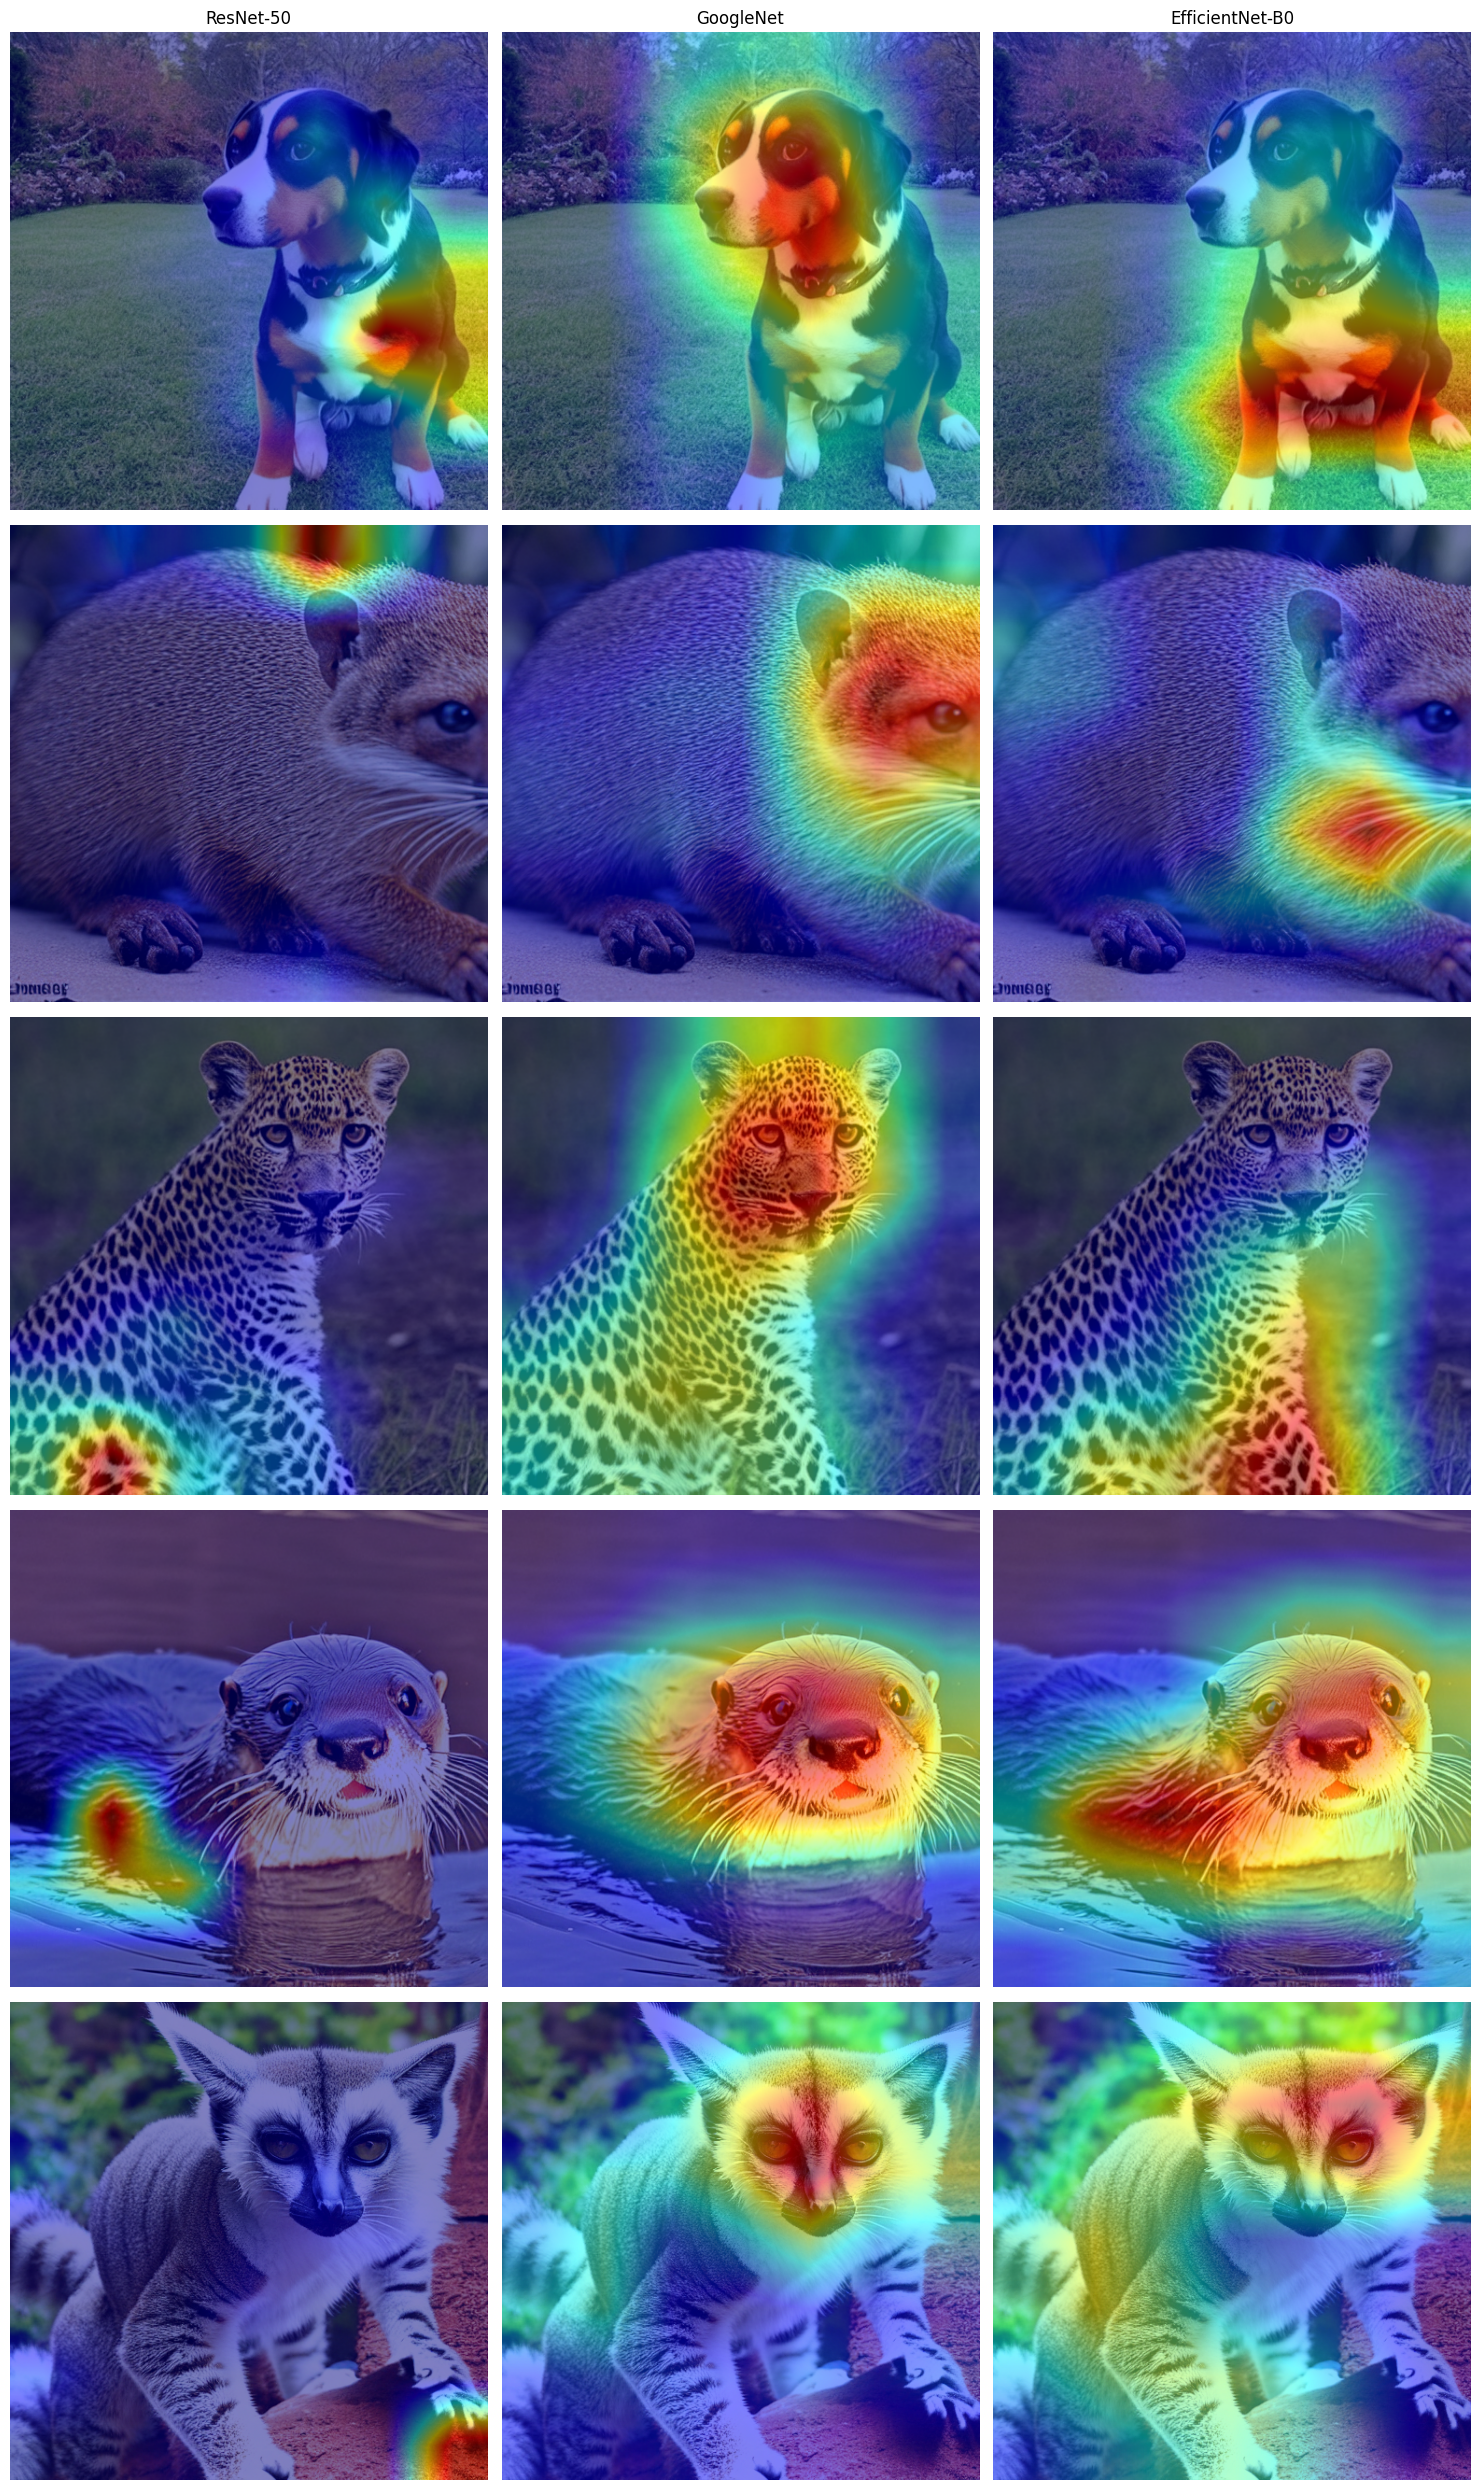

In [12]:
import os
import torch
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def preprocess_image_for_cam(img_path):
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)
    return img, input_tensor


models_with_layers = {
    "ResNet-50": (trained_models["ResNet-50"], "layer4[-1]"),
    "GoogleNet": (trained_models["GoogleNet"], "inception5b"),
    "EfficientNet-B0": (trained_models["EfficientNet-b0"], "features[-1]"),
}


def generate_gradcam_grid(models_with_layers, folder_path):
    """
    Generate Grad-CAM for all images in a folder for all models and display them in a grid.

    Args:
    - models_with_layers: Dictionary containing models and their target layers.
    - folder_path: Path to the folder containing images.
    """
    import builtins

    images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    cam_results = []

    for img_path in images:
        print(f"Processing image: {img_path}")


        img, input_tensor = preprocess_image_for_cam(img_path)
        input_tensor = input_tensor.to(device)
        input_tensor.requires_grad = True

        # Store Grad-CAM results for this image
        image_results = []

        for model_name, (model, target_layer_str) in models_with_layers.items():
            print(f"Generating Grad-CAM for {model_name}...")


            model.eval()


            target_layer = eval(f"model.{target_layer_str}")


            cam = GradCAM(model=model, target_layers=[target_layer])

            # Generate Grad-CAM
            try:
                grayscale_cam = cam(input_tensor=input_tensor)
                grayscale_cam = grayscale_cam[0, :]


                grayscale_cam_resized = cv2.resize(grayscale_cam, (img.size[0], img.size[1]))


                img_np = np.array(img) / 255.0
                cam_image = show_cam_on_image(img_np, grayscale_cam_resized, use_rgb=True)
                image_results.append(cam_image)
            except RuntimeError as e:
                print(f"Failed to generate Grad-CAM for {model_name} on {img_path}: {e}")
                image_results.append(None)

        cam_results.append(image_results)

    num_models = len(models_with_layers)
    num_images = len(images)
    fig, axes = plt.subplots(num_images, num_models, figsize=(5 * num_models, 5 * num_images))

    for i, image_results in enumerate(cam_results):
        for j, cam_image in enumerate(image_results):
            ax = axes[i, j] if num_images > 1 else axes[j]
            if cam_image is not None:
                ax.imshow(cam_image)
            else:
                ax.text(0.5, 0.5, "Failed", ha="center", va="center", fontsize=12, color="red")
            ax.axis("off")
            if i == 0:
                model_name = builtins.list(models_with_layers.keys())[j]
                ax.set_title(model_name, fontsize=12)

    plt.tight_layout()
    plt.show()


folder_path = "E:\Local\CSE493\dataset\diffusion\gradcam"


generate_gradcam_grid(models_with_layers, folder_path)